In [282]:
import pandas as pd
import requests
import math
import networkx as nx
import matplotlib.pyplot as plt
import itertools as it



In [ ]:
THE_GRAPH_TOKEN = "{your-token}"

In [ ]:
def the_graph_query_wrapper_v3(query, the_graph_token, variables = {}):

    # id is uniswap v3 subgraph
    endpoint = 'https://gateway.thegraph.com/api/subgraphs/id/{your-subgraph-id}'

    all_data = []
    headers = {
        'Authorization': f"Bearer {the_graph_token}",
        'Content-Type': 'application/json'
    }

    response = requests.post(
        endpoint,
        json={"query":query, "variables":variables},
        headers=headers
    )

    if response.status_code == 200:
        return response.json()

In [ ]:
def the_graph_query_wrapper_v2(query, the_graph_token, variables = {}):

    # id is uniswap v3 subgraph
    endpoint = 'https://gateway.thegraph.com/api/subgraphs/id/{your-subgraph-id}'
    

    all_data = []
    headers = {
        'Authorization': f"Bearer {the_graph_token}",
        'Content-Type': 'application/json'
    }

    response = requests.post(
        endpoint,
        json={"query":query, "variables":variables},
        headers=headers
    )

    if response.status_code == 200:
        return response.json()

In [286]:
transactions_query = """
{
  transactions(first: count, skip: skip_id, where: {blockNumber: block_number}) {
    id
    blockNumber
    timestamp
    gasUsed
    gasPrice
    swaps {
      id
      pool {
        id
        token0Price
        token1Price
        feeTier
        totalValueLockedUSD
        liquidity
      }
      token0 {
        id
        symbol
      }
      token1 {
        id
        symbol
      }
      sender
      recipient
      origin
      amount0
      amount1
      amountUSD
      sqrtPriceX96
      tick
      logIndex
    }
  }
}
"""

In [287]:

# block_number = 22338838
block_number = 22329398

In [288]:
q = transactions_query.replace('block_number', str(block_number)).replace("skip_id", str(0)).replace('count', str(1000))
print(q)


{
  transactions(first: 1000, skip: 0, where: {blockNumber: 22329398}) {
    id
    blockNumber
    timestamp
    gasUsed
    gasPrice
    swaps {
      id
      pool {
        id
        token0Price
        token1Price
        feeTier
        totalValueLockedUSD
        liquidity
      }
      token0 {
        id
        symbol
      }
      token1 {
        id
        symbol
      }
      sender
      recipient
      origin
      amount0
      amount1
      amountUSD
      sqrtPriceX96
      tick
      logIndex
    }
  }
}



In [289]:
res = the_graph_query_wrapper_v3(q, the_graph_token=THE_GRAPH_TOKEN)
res

{'data': {'transactions': [{'blockNumber': '22329398',
    'gasPrice': '572099204',
    'gasUsed': '0',
    'id': '0x0ab8dbf3fb84001beeb26940a811f4dab177bf8a34b1bdbfc2c2984eeb245281',
    'swaps': [{'amount0': '10.37206958',
      'amount1': '-10.345478',
      'amountUSD': '10.345478',
      'id': '0x0ab8dbf3fb84001beeb26940a811f4dab177bf8a34b1bdbfc2c2984eeb245281#15827',
      'logIndex': '679',
      'origin': '0x315147bb995c4c9b95e18a4321502469e06b877f',
      'pool': {'feeTier': '100',
       'id': '0x6838a1e5ae735c5c747044758254883c9f0f8a6a',
       'liquidity': '1613948075115008050',
       'token0Price': '1.002819847865997079782558148787024',
       'token1Price': '0.9971880813169008147737544350429782',
       'totalValueLockedUSD': '30287.78881309865554771881244691882'},
      'recipient': '0x0f4a1d7fdf4890be35e71f3e0bbc4a0ec377eca3',
      'sender': '0x0f4a1d7fdf4890be35e71f3e0bbc4a0ec377eca3',
      'sqrtPriceX96': '79130240969680609945137',
      'tick': '-276349',
      't

In [290]:
df = pd.DataFrame(res['data']['transactions'])
# df = df[df['id']=='0xfa361fcbd5684a7ebf657c610974dfbb6a030790516c37534d24af9fb8262c6e']
df = df[df['id'] == '0xea761c25e697c85150744c2a3a5d7ae9c4c250bccf80233faa921ee374c74c97']
df

,blockNumber,gasPrice,gasUsed,id,swaps,timestamp
27,22329398,478099204,0,0xea761c25e697c85150744c2a3a5d7ae9c4c250bccf80...,"[{'amount0': '4843.105964', 'amount1': '-4840....",1745383439


In [291]:
# Create a mapping of token symbols to indices
token_list = []


# Create a graph
G = nx.MultiDiGraph()

# Add edges for each pool using indices
for _, row in df.iterrows():
    for swap in row['swaps']:
        token0_symbol = swap['token0']['symbol']
        token1_symbol = swap['token1']['symbol']
        if token0_symbol not in token_list:
            token_list.append(token0_symbol)
            G.add_node(token0_symbol)
        
        if token1_symbol not in token_list:
            token_list.append(token1_symbol)
            G.add_node(token1_symbol)
        
        G.add_edge(token0_symbol, token1_symbol, weight=-1*math.log(float(swap['pool']['token1Price'])))
        G.add_edge(token1_symbol, token0_symbol, weight=-1*math.log(float(swap['pool']['token0Price'])))
        
        
#     token0 = row['token0_symbol']
#     token1 = row['token1_symbol']
#     if pd.notna(token0) and pd.notna(token1):
#         if float(row['token0Price']) == 0:
#             G.add_edge(token_to_index[token0], token_to_index[token1], weight=0)    
#         else:
#             G.add_edge(token_to_index[token0], token_to_index[token1], weight=math.log(float(row['token0Price'])) * -1)
            
#         if float(row['token1Price']) == 0:
#             G.add_edge(token_to_index[token1], token_to_index[token0], weight=0)
#         else:
#             G.add_edge(token_to_index[token1], token_to_index[token0], weight=math.log(float(row['token1Price'])) * -1)
# return G

In [292]:
def draw_labeled_multigraph(G, attr_name, ax=None):
    """
    Length of connectionstyle must be at least that of a maximum number of edges
    between pair of nodes. This number is maximum one-sided connections
    for directed graph and maximum total connections for undirected graph.
    """
    # Works with arc3 and angle3 connectionstyles
    connectionstyle = [f"arc3,rad={r}" for r in it.accumulate([0.15] * 4)]
    # connectionstyle = [f"angle3,angleA={r}" for r in it.accumulate([30] * 4)]

    pos = nx.shell_layout(G)
    nx.draw_networkx_nodes(G, pos, ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=20, ax=ax)
    nx.draw_networkx_edges(
        G, pos, edge_color="grey", connectionstyle=connectionstyle, ax=ax
    )

    labels = {
        tuple(edge): f"{attr_name}={attrs[attr_name]}"
        for *edge, attrs in G.edges(keys=True, data=True)
    }
    nx.draw_networkx_edge_labels(
        G,
        pos,
        labels,
        connectionstyle=connectionstyle,
        label_pos=0.3,
        font_color="blue",
        bbox={"alpha": 0},
        ax=ax,
    )

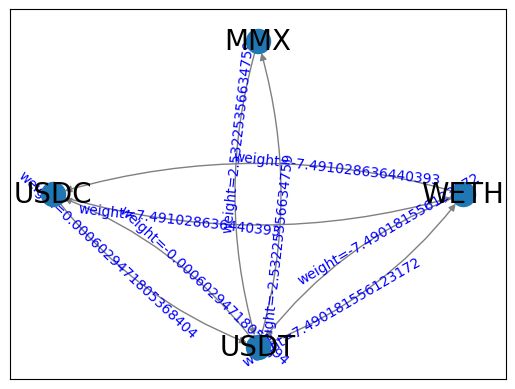

In [293]:
draw_labeled_multigraph(G, 'weight')

In [294]:
nx.negative_edge_cycle(G)

True